# CLUSTERING ALGORITHM

In this notebook, we explore the clustering of symptom data extracted from the dataset using natural language processing techniques.
The main steps involved are data preprocessing, vectorization of symptoms using Word2Vec, calculating cosine similarity between symptom vectors, and applying K-Means clustering to group similar symptoms.
We evaluate the clustering performance using metrics such as Silhouette coefficient, Davies-Bouldin Score, and Calinski-Harabasz Score, aiming to determine the optimal number of clusters.
Finally, we visualize the clustering results and discuss the insights gained from the analysis.

In [4]:
# # Import necessary libraries
import pandas as pd
import json
import numpy as np

from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [3]:
# Load and display the dataset
dg = pd.read_csv('ner_big_Vali_annotations.csv')
dg

,Unnamed: 0,text,entities
0,0,Chief Complaint:\n hypoxia / hypotension / fev...,"[{'start': 18, 'end': 25, 'piece': 'hypoxia', ..."
1,1,Chief Complaint:\n sepsis due to intra-abdomin...,"[{'start': 18, 'end': 24, 'piece': 'sepsis', '..."
2,2,Chief Complaint:\n chest pain\n\nHistory of Pr...,"[{'start': 18, 'end': 28, 'piece': 'chest pain..."
3,3,"Chief Complaint:\n fever to 103.0 at home, rle...","[{'start': 18, 'end': 23, 'piece': 'fever', 'l..."
4,4,"Chief Complaint:\n anemia, fatigue\n\nHistory ...","[{'start': 18, 'end': 24, 'piece': 'anemia', '..."
...,...,...,...
5431,5431,Chief Complaint:\n right-sided scapular pain\n...,"[{'start': 18, 'end': 43, 'piece': 'right-side..."
5432,5432,Chief Complaint:\n recurrent diverticulitis\n\...,"[{'start': 18, 'end': 42, 'piece': 'recurrent ..."
5433,5433,"Chief Complaint:\n generalized weakness, diffu...","[{'start': 18, 'end': 38, 'piece': 'generalize..."
5434,5434,"Chief Complaint:\n watery, nonbloody diarrhea\...","[{'start': 18, 'end': 44, 'piece': 'watery, no..."


In [5]:
first_entity = dg.at[0, 'entities']
print(first_entity)

[{'start': 18, 'end': 25, 'piece': 'hypoxia', 'label': 'Symptom'}, {'start': 28, 'end': 39, 'piece': 'hypotension', 'label': 'Symptom'}, {'start': 42, 'end': 47, 'piece': 'fever', 'label': 'Symptom'}, {'start': 136, 'end': 143, 'piece': 'hypoxia', 'label': 'Symptom'}, {'start': 148, 'end': 159, 'piece': 'hypotension', 'label': 'Symptom'}, {'start': 164, 'end': 169, 'piece': 'fever', 'label': 'Symptom'}, {'start': 197, 'end': 219, 'piece': 'right pleural effusion', 'label': 'Symptom'}, {'start': 342, 'end': 355, 'piece': 'eating poorly', 'label': 'Symptom'}, {'start': 459, 'end': 463, 'piece': 'cold', 'label': 'Symptom'}, {'start': 492, 'end': 502, 'piece': 'mild cough', 'label': 'Symptom'}, {'start': 545, 'end': 552, 'piece': 'hypoxic', 'label': 'Symptom'}, {'start': 565, 'end': 585, 'piece': 'respiratory distress', 'label': 'Symptom'}, {'start': 722, 'end': 742, 'piece': 'minimal urine output', 'label': 'Symptom'}, {'start': 770, 'end': 787, 'piece': 'continued hypoxia', 'label': 'Sym

In [6]:
# Extract the content of 'piece' and put it into the 'Symptoms' column
dg['Symptoms'] = dg['entities'].apply(lambda x: ', '.join([entity['piece'] for entity in eval(x)]))
print(dg)

      Unnamed: 0                                               text  \
0              0  Chief Complaint:\n hypoxia / hypotension / fev...   
1              1  Chief Complaint:\n sepsis due to intra-abdomin...   
2              2  Chief Complaint:\n chest pain\n\nHistory of Pr...   
3              3  Chief Complaint:\n fever to 103.0 at home, rle...   
4              4  Chief Complaint:\n anemia, fatigue\n\nHistory ...   
...          ...                                                ...   
5431        5431  Chief Complaint:\n right-sided scapular pain\n...   
5432        5432  Chief Complaint:\n recurrent diverticulitis\n\...   
5433        5433  Chief Complaint:\n generalized weakness, diffu...   
5434        5434  Chief Complaint:\n watery, nonbloody diarrhea\...   
5435        5435  Chief Complaint:\n endocarditis/ perivalvular ...   

                                               entities  \
0     [{'start': 18, 'end': 25, 'piece': 'hypoxia', ...   
1     [{'start': 18, 'end': 2

In [ ]:
dg

,Unnamed: 0,text,entities,Symptoms
0,0,Chief Complaint:\n hypoxia / hypotension / fev...,"[{'start': 18, 'end': 25, 'piece': 'hypoxia', ...","hypoxia, hypotension, fever, hypoxia, hypotens..."
1,1,Chief Complaint:\n sepsis due to intra-abdomin...,"[{'start': 18, 'end': 24, 'piece': 'sepsis', '...","sepsis, chronic subacute diverticulitis, febri..."
2,2,Chief Complaint:\n chest pain\n\nHistory of Pr...,"[{'start': 18, 'end': 28, 'piece': 'chest pain...","chest pain, chest pain, lifting, left sided ch..."
3,3,"Chief Complaint:\n fever to 103.0 at home, rle...","[{'start': 18, 'end': 23, 'piece': 'fever', 'l...","fever, rle pain, chills, rle pain, chills, rig..."
4,4,"Chief Complaint:\n anemia, fatigue\n\nHistory ...","[{'start': 18, 'end': 24, 'piece': 'anemia', '...","anemia, fatigue, anemia, fatigue, worsening, a..."
...,...,...,...,...
5431,5431,Chief Complaint:\n right-sided scapular pain\n...,"[{'start': 18, 'end': 43, 'piece': 'right-side...","right-sided scapular pain, nausea, two bowel m..."
5432,5432,Chief Complaint:\n recurrent diverticulitis\n\...,"[{'start': 18, 'end': 42, 'piece': 'recurrent ...","recurrent diverticulitis, diverticulitis, oral..."
5433,5433,"Chief Complaint:\n generalized weakness, diffu...","[{'start': 18, 'end': 38, 'piece': 'generalize...","generalized weakness, diffuse abdominal pain, ..."
5434,5434,"Chief Complaint:\n watery, nonbloody diarrhea\...","[{'start': 18, 'end': 44, 'piece': 'watery, no...","watery, nonbloody diarrhea, increasingly letha..."


In [7]:
# Explode each row based on symptoms present in the 'Symptoms' column
df = dg.assign(Symptoms=dg['Symptoms'].str.split(', ')).explode('Symptoms')

# Reset the index of the resulting DataFrame
df.reset_index(drop=True, inplace=True)

df


,Unnamed: 0,text,entities,Symptoms
0,0,Chief Complaint:\n hypoxia / hypotension / fev...,"[{'start': 18, 'end': 25, 'piece': 'hypoxia', ...",hypoxia
1,0,Chief Complaint:\n hypoxia / hypotension / fev...,"[{'start': 18, 'end': 25, 'piece': 'hypoxia', ...",hypotension
2,0,Chief Complaint:\n hypoxia / hypotension / fev...,"[{'start': 18, 'end': 25, 'piece': 'hypoxia', ...",fever
3,0,Chief Complaint:\n hypoxia / hypotension / fev...,"[{'start': 18, 'end': 25, 'piece': 'hypoxia', ...",hypoxia
4,0,Chief Complaint:\n hypoxia / hypotension / fev...,"[{'start': 18, 'end': 25, 'piece': 'hypoxia', ...",hypotension
...,...,...,...,...
52237,5435,Chief Complaint:\n endocarditis/ perivalvular ...,"[{'start': 18, 'end': 52, 'piece': 'endocardit...",lower back pain
52238,5435,Chief Complaint:\n endocarditis/ perivalvular ...,"[{'start': 18, 'end': 52, 'piece': 'endocardit...",low grade temp
52239,5435,Chief Complaint:\n endocarditis/ perivalvular ...,"[{'start': 18, 'end': 52, 'piece': 'endocardit...",chronic lower back pain
52240,5435,Chief Complaint:\n endocarditis/ perivalvular ...,"[{'start': 18, 'end': 52, 'piece': 'endocardit...",severe lower back pain


In [8]:
# Ottenere tutti i sintomi unici
unique_symptoms = df['Symptoms'].unique()

# Creare un nuovo DataFrame con i sintomi unici
unique_symptoms_df = pd.DataFrame(unique_symptoms, columns=['Symptoms'])

unique_symptoms_df


,Symptoms
0,hypoxia
1,hypotension
2,fever
3,right pleural effusion
4,eating poorly
...,...
13444,blood pressure progressively fell
13445,endocarditis/ perivalvular abscess
13446,right facial numbness
13447,perivalvular abscess


# DATA PREPROCESSING

Below are implemented the same steps carried out on the "KINBIOTICS_NER" dataset: preprocessing of symptom data, training of the Word2Vec model to generate vector representations for each symptom, and calculation of cosine similarity between symptom vectors.

In [9]:
# Data preprocessing
symptoms_processed = unique_symptoms_df['Symptoms'].str.lower().str.replace(",", "").str.split()

# Train the Word2Vec model on symptoms data
word2vec_model = Word2Vec(sentences=symptoms_processed, vector_size=100, window=5, min_count=1, sg=1)

# Calculate the average vector representation for each symptom
symptoms_vectors = []
for words in symptoms_processed:
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if vectors:  # Check se ci sono vettori validi
        mean_vector = np.mean(vectors, axis=0)
        symptoms_vectors.append(mean_vector)
    else:
        symptoms_vectors.append(np.zeros(word2vec_model.vector_size))  # Aggiungi un vettore di zeri se non ci sono parole valide

# Convert the list of vectors into a numpy array
symptoms_vectors = np.array(symptoms_vectors)

# Calculate the cosine similarity between symptom vectors
cosine_similarities = cosine_similarity(symptoms_vectors)

# Clustering evaluation

Here again we evaluate the best number of clusters using the three metrics previously involved: Shilouette Score, Davies-Bouldi Score,
Calinski-Harabasz Score.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

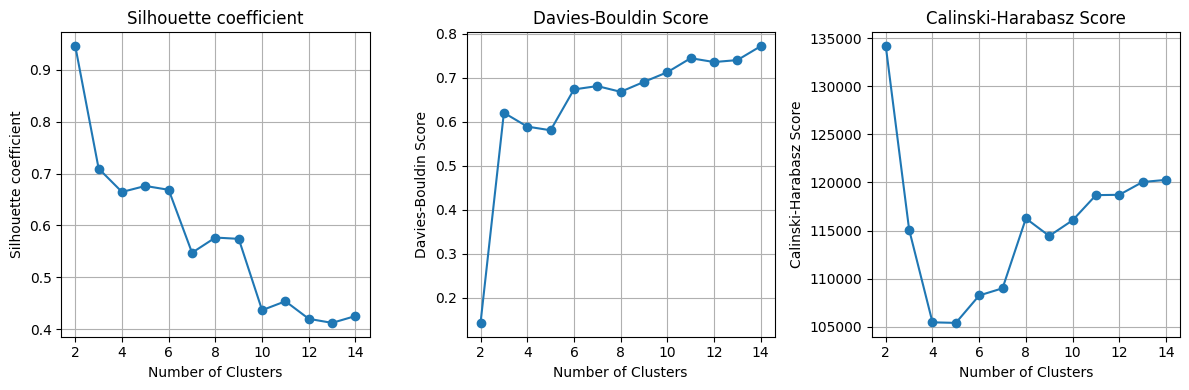

In [13]:
# Calculate the cosine similarity between symptom vectors
cosine_similarities = cosine_similarity(symptoms_vectors)

# Calculate Silhouette coefficient, Davies-Bouldin score, and Calinski-Harabasz score for different numbers of clusters
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

possible_num_clusters = range(2, 15)  # Try from 2 to 14 clusters
for num_clusters in possible_num_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(cosine_similarities)

    silhouette_scores.append(silhouette_score(cosine_similarities, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(cosine_similarities, cluster_labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(cosine_similarities, cluster_labels))

# Visualize the plots for different metrics
plt.figure(figsize=(12, 4))

# Higher values are desired
plt.subplot(1, 3, 1)
plt.plot(possible_num_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette coefficient')
plt.grid(True)

# Lower values are desired
plt.subplot(1, 3, 2)
plt.plot(possible_num_clusters, davies_bouldin_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score')
plt.grid(True)

# Higher values are desired
plt.subplot(1, 3, 3)
plt.plot(possible_num_clusters, calinski_harabasz_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score')
plt.grid(True)

plt.tight_layout()
plt.show()


# Clustering

Here again, we chose to implement the K-Means algorithm and considered 11 clusters because it appeared to be the best choice for achieving a satisfactory clustering result, even if the performance reached was lower than the one obtained by implementing the same procedure on KINBIOTICS_NER.

In [14]:
# Apply the clustering algorithm (e.g., K-Means) on the sampled data
num_clusters = 11
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(cosine_similarities)

# Add cluster labels to the DataFrame
unique_symptoms_df['Cluster'] = cluster_labels

# Print the results
print("Clustering results:")
print(unique_symptoms_df[['Symptoms', 'Cluster']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clustering results:
                                 Symptoms  Cluster
0                                 hypoxia        8
1                             hypotension        8
2                                   fever        8
3                  right pleural effusion        0
4                           eating poorly        8
...                                   ...      ...
13444   blood pressure progressively fell        8
13445  endocarditis/ perivalvular abscess        2
13446               right facial numbness        6
13447                perivalvular abscess        2
13448                   extreme back pain        6

[13449 rows x 2 columns]


In [ ]:
# Print the elements of each cluster
for cluster_id in range(num_clusters):
    print("Cluster", cluster_id)
    cluster_elements = unique_symptoms_df[unique_symptoms_df['Cluster'] == cluster_id]['Symptoms'].values
    for symptom in cluster_elements:
        print("-", symptom)
    print()

In [15]:
# Print the number of elements in each cluster
for cluster_id in range(num_clusters):
    cluster_elements_count = len(unique_symptoms_df[unique_symptoms_df['Cluster'] == cluster_id])
    print("Cluster", cluster_id, "has", cluster_elements_count, "elements")


Cluster 0 has 547 elements
Cluster 1 has 180 elements
Cluster 2 has 2700 elements
Cluster 3 has 971 elements
Cluster 4 has 53 elements
Cluster 5 has 163 elements
Cluster 6 has 1204 elements
Cluster 7 has 167 elements
Cluster 8 has 7005 elements
Cluster 9 has 376 elements
Cluster 10 has 83 elements


In [16]:
# Specify the cluster ID of interest
cluster_id_of_interest = 1  # Change this value with the desired cluster ID (from 0 to 10)

# Print the elements of the specified cluster
print("Elements of cluster", cluster_id_of_interest)
cluster_elements = unique_symptoms_df[unique_symptoms_df['Cluster'] == cluster_id_of_interest]['Symptoms'].values
for symptom in cluster_elements:
    print("-", symptom)


Elements of cluster 1
- aspergillus
- non-productive)
- 
- dysnpea
- penumonia
- cruise
- dizziness.
- enteroccus
- c-diff
- "cholelithiasis
- e-coli
- symtoms
- -diff
- dka
- forgetful
- emphysema
- hypoptension
- pan-colitis
- adenitis
- shakes
- loperamide
- shaking"
- hyperkalemic
- jumpy"
- gelfoam
- hallucinating
- gpr
- nonresponsive
- hepatosplenomegaly
- rifamixin
- atherosclerosis
- dypnea
- hyperlipidemia
- intoxicated
- peptostreptococcus
- pancytopenic
- letheargic
- pancolitis
- benadryl
- hepatotoxic
- pna/bacteremia
- completeness
- pericentesis
- dysphonia
- diahhrea
- lighteheadedness
- gastritis/duodenitis
- controled
- uti/bacteremia
- cryptococcus
- hypoperfusion
- systolics
- galactomannin
- "changes"
- pesudeomonas
- epinephrine
- non-pleuritic
- unremitting
- +staph
- osa
- benzos
- tachypnia
- unsuccessfully
- light-headedness
- multi-trauma
- rash/cellulitis
- non-verbal"
- non-radiating
- gibberish"
- gastritis/trauma
- ossa
- acidotic
- bradiacardia
- hyperc

After completing the data analysis and clustering process, it is important to reflect on the nature of the identified clusters and their representativeness with respect to specific health issues.

It is evident that the identified clusters are not representative of specific health problems. This is mainly due to the lack of consistency in symptoms and the presence of multiple variables involved in the clustering process. The symptoms listed in the data are extremely heterogeneous and can indicate a wide range of potential disorders. This heterogeneity makes it difficult to group the data into clusters representing specific medical conditions.

Furthermore, symptom overlap and individual variability further contribute to the challenge of identifying clear patterns in the data. Many symptoms can be present in multiple medical conditions, while patient responses to symptoms can vary significantly from individual to individual.

It should be noted that, although it may be possible to identify more defined patterns in a smaller cluster (as was possible, to some extent, by implementing the algorithm on the KINBIOTICS_NER dataset), as the number of symptoms increases (in this dataset we counted 13449), it becomes more difficult to group the data into coherent and meaningful clusters.

In conclusion, it is important to consider the challenges and limitations encountered during the clustering process when using data analysis techniques related to health. This helps us develop critical awareness of the results obtained and identify areas for improvement for future studies.